# Rovibronic states

The sum-over-states expressions for response functions are expressed in terms of the exact rovibronic eigenstates of the molecular Hamiltonian in the absence of external fields. These states are rarely available in practical calculations, where instead electronic states are employed. However, for a diatomic system, we can determine the rovibrational wave functions and the associated transition moments and energies.

## Rovibrational spectroscopy for diatomic molecules

In a diatomic molecule there are sequences of quantized **rotational** levels associated with the ground and excited **vibrational** levels. The transitions between rotational levels from a vibrational state to other are called bands, and depending on the difference in the rotational quantum number ($J$) we classify the bands in:

1. Q-branch: when $\Delta J = 0$
2. R-branch: when $\Delta J = +1$
3. P-branch: when $\Delta J = -1$

Before digging more into the theoretical determination of the branches, we need first a method to get the wave functions for the different vibrational levels, i.e., solving the Schrödinger equation for a given potential.

## Numerov's method for solving the Schrödinger equation

Numerov's method can be employed to solve 1D differential equations using finite differences over a grid. 

The radial Schrödinger equation for a diatomic system takes the form

$$   
[- \dfrac {\hbar^{2}} {2 m} ... + V (R)] \chi_n(R) = 
E_n \chi_n(R)  
$$

where $m$ is the reduced mass.

## Numerov's method in VeloxChem

We start by importing the modules and setting up the system

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx

The system that we will use as an example is HCl.

In [68]:
molecule_string = """
Cl   0.0     0.0   0.0
H    1.274   0.0   0.0
"""

molecule = vlx.Molecule.read_str(molecule_string, units="angs")
basis_set_label = "6-31+G"
basis = vlx.MolecularBasis.read(molecule, basis_set_label)
molecule.set_charge(0)
molecule.set_multiplicity(1)

scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp", "grid_level": 4}

To run the Numerov driver in VeloxChem we need to define the settings in a dictionary. We can consult all the settings as follows: 

In [69]:
num_drv = vlx.NumerovDriver()
num_drv.print_keywords()

                       @numerov                                                                                           
                     --------------------------------------------------------------------------------                     
                       pec_displacements   sequence       PEC scanning range [bohr]                                       
                       pec_potential       string         potential type for fitting                                      
                       reduced_mass        float          reduced mass of the molecule                                    
                       el_transition       boolean        include an electronic transition                                
                       final_el_state      integer        final state of the electronic transition                        
                       exc_conv_thresh     float          excited state calculation threshold                             
                

Now we proceed with the calculation, the potential $V(R)$ will be calculated by mapping the bond distance and we can decide if we want to fit it with a harmonic or a Morse potential. As a disclaimer the Morse potential will work fine for as many vibrational excited states as we want meanwhile the harmonic will work only for the lower ones as it is not able to reproduce the dissociation limit.

In [70]:
numerov_settings = {
    "n_vib_states": 15,
    "pec_displacements": "-0.7 - 2.0 (0.1)",
    "el_transition": "no",
    "pec_potential": "morse",
    "n_rot_states": 15,
}
num_drv.update_settings(numerov_settings, scf_settings, method_settings)
num_results = num_drv.compute(molecule, basis)

                                                                                                                          
                                           Potential Energy Curve Driver Setup                                            
                                                                                                                          
                              Number of Geometries          : 28                                                          
                              Wave Function Model           : Spin-Unrestricted Kohn-Sham                                 
                              SCF Convergece Threshold      : 1.0e-06                                                     
                              DFT Functional                : B3LYP                                                       
                              Molecular Grid Level          : 4                                                           
                

The results are stored in a dictionary.

In [71]:
print(num_results.keys())

dict_keys(['grid', 'potential', 'psi', 'vib_levels', 'excitation_energies', 'oscillator_strengths'])


In [72]:
grid = num_results["grid"]
potential = num_results["potential"]
psi = num_results["psi"]
vib_levels = num_results["vib_levels"]
displacements = num_drv.pec_displacements
energies = num_drv.pec_energies["i"]
psi_squared = psi**2
exc = num_results["excitation_energies"]
osc = num_results["oscillator_strengths"]

The vibrational levels can be plotted against the potential energy curve.

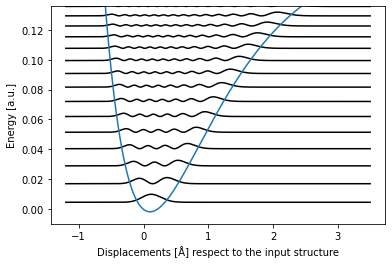

In [80]:
fig, ax1 = plt.subplots()

for i in range(len(psi_squared)):
    ax1.plot(grid, [float(x) + vib_levels[i] for x in psi_squared[i]], "k")

ax = plt.subplot()
ax.plot(grid, potential)
ax.set_ylim(-0.01, vib_levels[-1])
ax.set_xlabel("Displacements [Å] respect to the input structure")
ax.set_ylabel("Energy [a.u.]")

plt.show()

## Rovibrational spectra

Once we have the vibrational wave functions we can calculate the dipole transition moments

$$ 
\mu^{fi} = \langle \nu_{f} | \mu^\mathrm{e}(R) | \nu_{i} \rangle
$$

where $\mu^\mathrm{e}(R)$ is the dipole moment at internuclear separation distance $R$.

Only the first transition dipole moment (corresponding to the Q-branch) is relevant and the rest are negligible. We will obtain the fine structure by deriving the rotational excited states for the R and P branches.

Applying the rotational selection rules derived for linear molecules, we get the P-branch

$$ 
E = \hbar \omega_{\text{stretch}} + \left( \dfrac{h^2}{8\pi^2I} \right)((L - 1)L - L(L + 1)) = \hbar \omega_{\text{stretch}} -2\left( \dfrac{h^2}{8\pi^2 I} \right)L 
$$

and the R-branch

$$
E = \hbar \omega_{\text{stretch}} + \left( \dfrac{h^2}{8\pi^2I} \right)((L+1)(L+2) - L(L + 1)) = \hbar \omega_{\text{stretch}} + 2\left( \dfrac{h^2}{8\pi^2I} \right)(L + 1) $$

where

$$ 
I = \frac{m_a m_b}{m_a + m_b} R^2 
$$ 

VeloxChem takes care of the spectra and the branches storing the data on the keys: `excitation_energies` and `oscillator_strengths`.

As well, computes the dipole moment for every point of the potential energy curve

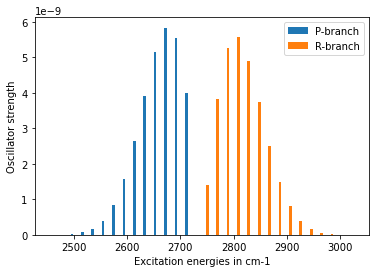

In [78]:
ax1 = plt.bar(exc["P"], osc["P"], width=5.0)
ax2 = plt.bar(exc["R"], osc["R"], width=5.0)
branches = (ax1, ax2)
labels = list({"P-branch", "R-branch"})
plt.xlabel("Excitation energies in cm-1")
plt.ylabel("Oscillator strength")
plt.legend(branches, labels)

plt.show()

## Rovibronic transitions: UV spectrum

In this case, we want to consider the transition dipole moments between rovibrational states in different electronic states. The expression for the transition dipole integral in this case will involve different electronic states, so it's in essence, a generalization of the expression for the vibrational transition dipole moment.

The electronic transition dipole moment equals

$$ 
\mu^{fi}(R) = \langle \psi^\mathrm{e}_{f} | \hat{\mu} | \psi^\mathrm{e}_{i} \rangle
$$

where $\psi^\mathrm{e}_{f}$ and $\psi^\mathrm{e}_{i}$ are the final and initial electronic wave function, respectively. 

Expanding the transition moment in a power series about the equilibrium distance, we get

$$ \mu_{f,i}(\textbf{R}) = \mu_{f,i}(\textbf{R}_e) + \sum\limits_a \dfrac{\partial \mu_{f,i}}{\partial R_a} (R_a - R_{a,e}) + \cdots . $$ 

Now, by truncating this expression in the first term we get the so called Frank-Condon approximation. We could also include the second term with is reffered as the Herzberg-Teller correction. But for out purposes we will go with the Frank-Condon approximation. <br />
In that framework, transition energies can be obtained as: <br />
$$ f_{if} = \frac{2}{3} \omega_{nl} \sum_{\alpha}^{x,y,z} | \langle \phi_n \langle \psi_i | \mu_{\alpha} | \psi_f \rangle \phi'_l \rangle |^2   $$
Being $\psi_i,\psi_f$ the initial and final electronic wavefunctions <br />
And $\phi_n, \phi'_l$ the vibrational wavefunctions of the initial and final electronic states  <br />

Now, the only difference with respect to the pure rovibrational spectrum is that we are going to include an excited state

In [79]:
numerov_settings = {
    "n_vib_states": 10,
    "pec_displacements": "-0.7 - 2.0 (0.1)",
    "el_transition": "yes",
    "final_el_state": 2,
    "pec_potential": "morse",
}
num_drv.update_settings(numerov_settings, scf_settings, method_settings)
num_results = num_drv.compute(molecule, basis)

                                                                                                                          
                                           Potential Energy Curve Driver Setup                                            
                                                                                                                          
                              Number of Geometries          : 28                                                          
                              Wave Function Model           : Spin-Unrestricted Kohn-Sham                                 
                              SCF Convergece Threshold      : 1.0e-06                                                     
                              DFT Functional                : B3LYP                                                       
                              Molecular Grid Level          : 4                                                           
                

The results will be stored as keys that we can see here:

In [52]:
print(num_results.keys())

dict_keys(['grid', 'i_potential', 'i_psi', 'i_vib_levels', 'f_potential', 'f_psi', 'f_vib_levels', 'excitation_energies', 'oscillator_strengths'])


We store the results in variables:

In [53]:
grid = num_results["grid"]
gs_potential = num_results["i_potential"]
gs_psi = num_results["i_psi"]
gs_vib_levels = num_results["i_vib_levels"]
es_potential = num_results["f_potential"]
es_psi = num_results["f_psi"]
es_vib_levels = num_results["f_vib_levels"]

exc = num_results["excitation_energies"]
osc = num_results["oscillator_strengths"]

For the purposes of the representation of the vibrational levels in both electronic states we will store also this variables:

In [54]:
displacements = num_drv.pec_displacements
gs_energies = num_drv.pec_energies["i"]
es_energies = num_drv.pec_energies["f"]

# relative potentials:
rel_es_potential = es_potential + (np.min(es_energies) - np.min(gs_energies))

# relative excited state vibrational levels:
rel_es_vib_levels = es_vib_levels + (np.min(es_energies) - np.min(gs_energies))

gs_psi_squared = gs_psi**2
es_psi_squared = es_psi**2

The vibrational levels can be then plotted against the potential energy curves:

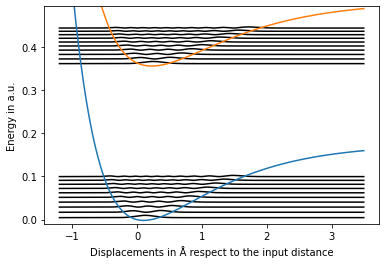

In [55]:
fig, ax1 = plt.subplots()
for i in range(len(gs_psi_squared)):
    ax1.plot(grid, [float(x) + gs_vib_levels[i] for x in gs_psi_squared[i]], "k")
    ax1.plot(grid, [float(x) + rel_es_vib_levels[i] for x in es_psi_squared[i]], "k")

ax = plt.subplot()
ax.plot(grid, gs_potential)
ax.plot(grid, rel_es_potential)
ax.set_ylim(-0.01, rel_es_vib_levels[-1] + 0.05)
ax.set_xlabel("Displacements in Å respect to the input distance")
ax.set_ylabel("Energy in a.u.")

plt.show()

Now we can just plot the spectrum by representing the results from the driver:

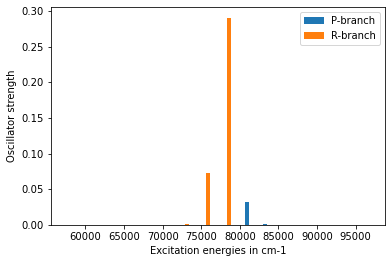

In [56]:
plt.bar(exc["absorption"], osc["absorption"], width=500.0, label="absorption")
plt.bar(exc["emission"], osc["emission"], width=500.0, label="emission")

plt.legend(labels)
plt.xlabel("Excitation energies in cm-1")
plt.ylabel("Oscillator strength")

plt.show()

## User defined potential

If you want to just explore the equations and have your own potentials and transition moments you can define them by using the method `read_pec_data` from the Numerov driver to get the wavefunctions and compute the UV spectrum as follows: 

In [57]:
num_drv = vlx.NumerovDriver()

Definition of the user potentials: In this example we will use two harmonic potentials and a linear polarization with respect to the nuclear displacement.

In [58]:
new_bond_lengths = np.arange(-0.7, 2.01, 0.1)
new_gs_energies = [0.75 * x**2 for x in new_bond_lengths]
new_es_energies = [0.5 * (x - 0.35) ** 2 + 0.4 for x in new_bond_lengths]
new_properties = [[0, 0.1, 0.1] for x in new_bond_lengths]

Also we will use an example reduced mass of 1 and to the bond lenghts we will add 2 Å to the right to account the shift between the ground and excited electronic states:

In [59]:
num_drv.read_pec_data(
    new_bond_lengths + 2.0, new_properties, new_gs_energies, new_es_energies
)
num_drv.set_reduced_mass(1)
numerov_settings = {
    "n_vib_states": 10,
    "el_transition": "yes",
    "final_el_state": 1,
    "pec_potential": "harmonic",
}
num_drv.update_settings(numerov_settings, scf_settings, method_settings)

In [60]:
model_results = num_drv.compute()

                                                                                                                          
                                                   Numerov Driver Setup                                                   
                                                                                                                          
                                         Number of Vibrational States : 10                                                
                                         Energy Convergence Threshold : 1.0e-12                                           
                                         Max. Number of Iterations    : 1000                                              
                                         Grid Points per Bohr Radius  : 500                                               
                                         Margin right of scanned PEC  : 1.50                                              
                

As usual we store the results in variables:

In [61]:
grid = model_results["grid"]
gs_potential = model_results["i_potential"]
gs_psi = model_results["i_psi"]
gs_vib_levels = model_results["i_vib_levels"]
es_potential = model_results["f_potential"]
es_psi = model_results["f_psi"]
es_vib_levels = model_results["f_vib_levels"]

exc = model_results["excitation_energies"]
osc = model_results["oscillator_strengths"]

In [62]:
displacements = num_drv.pec_displacements
gs_energies = num_drv.pec_energies["i"]
es_energies = num_drv.pec_energies["f"]

# relative potentials:
rel_es_potential = es_potential + (np.min(es_energies) - np.min(gs_energies))

# relative excited state vibrational levels:
rel_es_vib_levels = es_vib_levels + (np.min(es_energies) - np.min(gs_energies))

gs_psi_squared = gs_psi**2
es_psi_squared = es_psi**2

We can now visualize the vibrational levels against the potential energy curves:

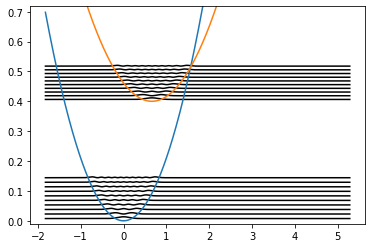

In [63]:
fig, ax1 = plt.subplots()
for i in range(len(gs_psi_squared)):

    ax1.plot(grid, [float(x) + gs_vib_levels[i] for x in gs_psi_squared[i]], "k")
    ax1.plot(grid, [float(x) + rel_es_vib_levels[i] for x in es_psi_squared[i]], "k")

ax = plt.subplot()
ax.plot(grid, gs_potential)
ax.plot(grid, rel_es_potential)
ax.set_ylim(-0.01, rel_es_vib_levels[-1] + 0.2)

plt.show()

And we plot the UV spectrum by using the results from the driver:

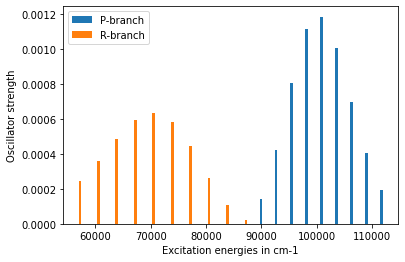

In [64]:
plt.bar(exc["absorption"], osc["absorption"], width=500.0, label="Absorption")
plt.bar(exc["emission"], osc["emission"], width=500.0, label="Emission")

plt.legend(labels)
plt.xlabel("Excitation energies in cm-1")
plt.ylabel("Oscillator strength")

plt.show()